<a href="https://colab.research.google.com/github/rickiepark/MLQandAI/blob/main/supplementary/q26_conformal-prediction/conformal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컨포멀 예측

In [1]:
!pip install --quiet watermark

%load_ext watermark
%watermark -p scikit-learn,mapie,numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00
scikit-learn: 1.6.0
mapie       : not installed
numpy       : 1.26.4



## 데이터셋 준비

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


iris = load_iris()
X = iris.data
y = iris.target

X_, X_test, y_, y_test = train_test_split(
    X, y, test_size=0.015, random_state=123, stratify=y)

# 훈련 세트와 보정 세트로 나눕니다.
X_train, X_calib, y_train, y_calib = train_test_split(
    X_, y_, test_size=0.5, random_state=123, stratify=y_)

## 모델 훈련

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=123, solver="newton-cg")

model.fit(X_train, y_train);

## 예측 생성

In [4]:
pred = model.predict_proba(X_calib)

# pred의 크기는 [n_samples, n_classes]
pred.shape

(74, 3)

In [5]:
# 각각 세 개의 확률 점수를 가지며 한 클래스만 1입니다
pred[0] # 첫 번째 예측

array([3.58472245e-06, 2.06334809e-02, 9.79362934e-01])

# 밑바닥부터 컨포멀 예측 만들기

#### 백분위 임곗값 계산하기

In [6]:
confidence_level = 0.95

In [7]:
import numpy as np


# 정답 클래스 레이블에 해당하는 확률을 선택합니다.
proba_true = pred[np.arange(y_calib.shape[0]), y_calib]
print(proba_true.shape)

(74,)


In [8]:
# 비적합성 점수를 계산합니다.
nc_scores = 1 - proba_true

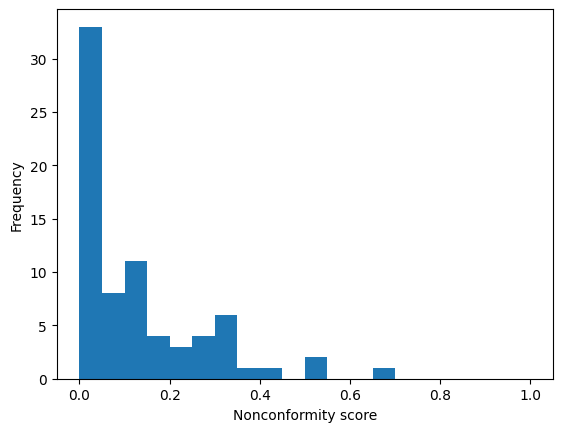

In [9]:
import matplotlib.pyplot as plt

plt.hist(nc_scores, bins=20, range=[0, 1])
plt.xlabel("Nonconformity score")
plt.ylabel("Frequency")
plt.show()

In [10]:
# 유한 표본 수정을 적용합니다.
n = y_calib.shape[0]

q_level = np.ceil((n+1)*(confidence_level))/n
q_level

0.972972972972973

In [11]:
# 95%의 경우가 포함되도록 임곗값을 선택합니다.
thres = np.quantile(nc_scores, q_level, method="higher")
thres

0.547685088730951

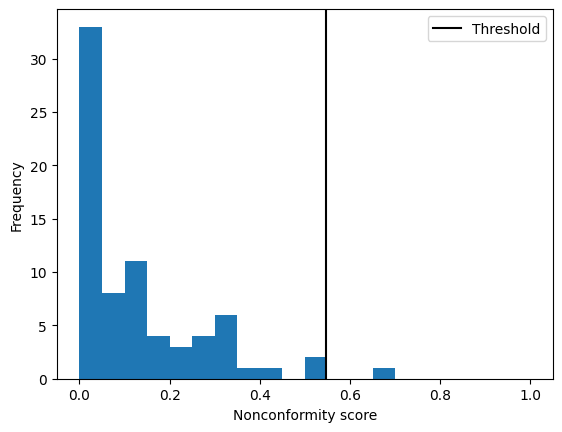

In [12]:
import matplotlib.pyplot as plt

plt.hist(nc_scores, bins=20, range=[0, 1])
plt.axvline(thres, color="black", label="Threshold")
plt.xlabel("Nonconformity score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### 새로운 데이터에 대한 예측 계산하기

In [13]:
test_nc_scores = 1 - model.predict_proba(X_test)

prediction_sets = test_nc_scores <= thres

prediction_sets

array([[False,  True,  True],
       [ True, False, False],
       [False, False,  True]])

In [14]:
class_names = np.array(["Setosa", "Versicolor", "Virginica"])

for row in prediction_sets:
    print(class_names[row])

['Versicolor' 'Virginica']
['Setosa']
['Virginica']


# MAPIE를 사용한 컨포멀 예측

- MAPIE 문서: https://mapie.readthedocs.io/
- 이 코드는 Christoph Molnar의 책 [Conformal Prediction](https://christophmolnar.com/books/conformal-prediction/)을 참고했습니다.

In [16]:
!pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [17]:
from mapie.classification import MapieClassifier


cp = MapieClassifier(estimator=model, cv="prefit", method="score")
cp.fit(X_calib, y_calib)

MapieClassifier(cv='prefit',
                estimator=LogisticRegression(random_state=123,
                                             solver='newton-cg'),
                method='score')

In [18]:
y_pred, y_set = cp.predict(X_test, alpha=1-confidence_level)
y_set = np.squeeze(y_set)
y_set

array([[False,  True,  True],
       [ True, False, False],
       [False, False,  True]])

In [19]:
for row in y_set:
    print(class_names[row])

['Versicolor' 'Virginica']
['Setosa']
['Virginica']
